# Introduction to Radiation Dosage Computation from Galactic Cosmic Rays (GCR)

## Overview

Radiation detectors such as RADEM play a crucial role in measuring and analyzing various types of radiation in our environment, especially in space applications where exposure to cosmic radiation is a significant concern. Among the different sources of radiation, Galactic Cosmic Rays (GCR) are high-energy particles that originate from outside our solar system.

In this Jupyter Notebook, we will demonstrate how to compute the total dosage deposited on a radiation detector based on the GCR spectrum. Using RADEM data we'll isolate periods of solar activity from the measurements assuring that we've only counted GCR particles into our analysis. This information might be critical for evaluating the effectiveness of radiation shielding, monitoring astronaut safety during space missions, and advancing our understanding of space radiation hazards.

## Importing required dependencies
To perform this analysis we'll have to import a few tools. This also includes the `radem` library.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import radem
from pathlib import Path


## Loading data
We'll base our analysis on the proton data from the RADEM detector. If you've gone throught the `data_conversions.ipynb` tutorial you should be able to load RADEM data from either the `.cdf`, `.csv` or `.hdf` files.

In [6]:
hdf_file_path = Path('../data/processed/data.h5')
hdf_file_path.exists()

True

In [7]:
df_p, df_e, df_d, df_h = radem.loaders.load_hdf5(hdf_file_path)
print(df_p.head(9))

                 time  bin  value
0 2023-09-01 00:00:56    1      6
1 2023-09-01 00:00:56    2    222
2 2023-09-01 00:00:56    3     27
3 2023-09-01 00:00:56    4     21
4 2023-09-01 00:00:56    5     18
5 2023-09-01 00:00:56    6     39
6 2023-09-01 00:00:56    7     35
7 2023-09-01 00:00:56    8     23
8 2023-09-01 00:00:56    9      0


## Selecting the Correct Time Interval for Analysis
Selecting an appropriate time window is crucial, as it directly influences the integrity of the analysis outcomes.

Calibration artifacts — periods when instruments are being adjusted or tested, can introduce misleading signals that do not accurately represent the true radiation environment. Similarly, instances when detectors are down for maintenance can lead to gaps or inaccuracies in the data. These factors can obscure meaningful trends and potentially lead to incorrect conclusions about radiation exposure or environmental conditions. Additionally we have to consider the trends in our data when using background detection algorithms such as the one in this example.

For the purpouses of this analysis we'll be using the period from 2024-01-01 to 2024-03-01 - two months of data. 

In [8]:
df = df_e.query("bin == 1 and time > '2023-09-01' and time < '2024-01-01'")
df.head()

,time,bin,value
0,2023-09-01 00:00:56,1,5
16,2023-09-01 00:01:56,1,4
25,2023-09-01 00:02:56,1,6
35,2023-09-01 00:03:56,1,4
43,2023-09-01 00:04:56,1,2


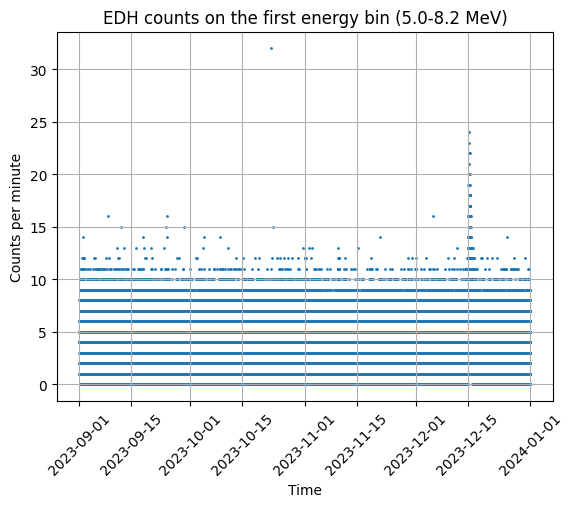

In [9]:
fig, ax = plt.subplots()
df.plot.scatter(x='time', 
                y='value', 
                title="EDH counts on the first energy bin (5.0-8.2 MeV)",
                xlabel="Time",
                ylabel="Counts per minute",
                s=1, ax=ax)
ax.grid()
ax.tick_params(axis='x', rotation=45);


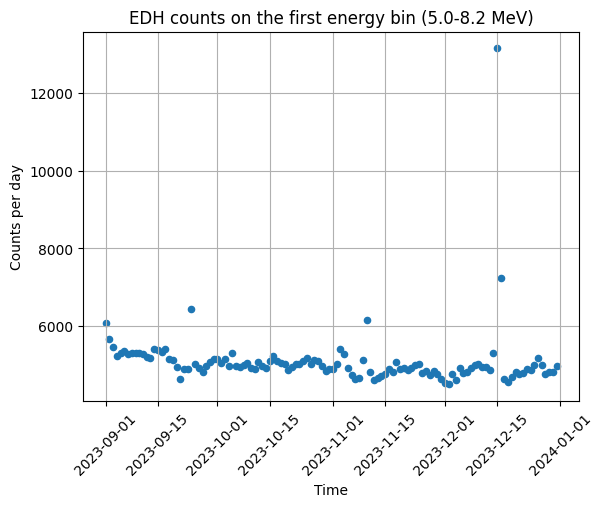

In [10]:
fig, ax = plt.subplots()
df.groupby(pd.Grouper(key='time', freq='D'))['value'].sum().reset_index().plot(x='time', 
                y='value', 
                title="EDH counts on the first energy bin (5.0-8.2 MeV)",
                xlabel="Time",
                ylabel="Counts per day",
                kind='scatter',
                ax=ax)
ax.grid()
ax.tick_params(axis='x', rotation=45);


We can agregate the data for an entire day using a simple mean strategy to create a more legible plot.

## Let's pick some samples to asses their distributions

In [11]:
sample_1 = df_e.query("bin == 1 and time >= '2023-10-01' and time < '2023-11-01'")
sample_2 = df_e.query("bin == 1 and time >= '2023-11-15' and time < '2023-12-01'")

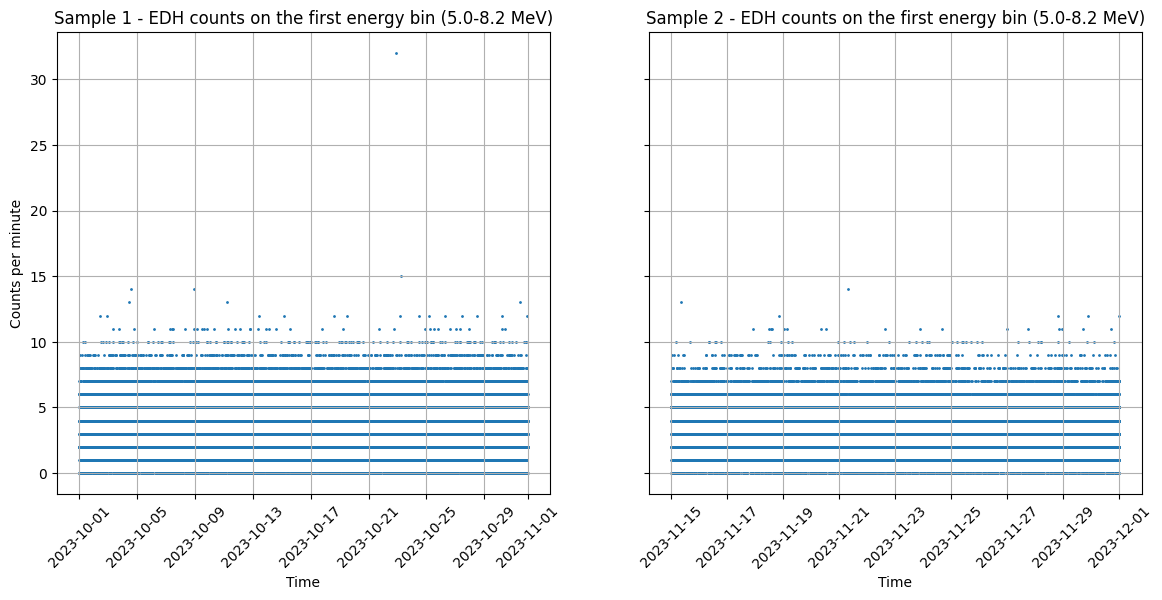

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

sample_1.plot.scatter(x='time', y='value', s=1, ax=ax[0], title="Sample 1 - EDH counts on the first energy bin (5.0-8.2 MeV)")
sample_2.plot.scatter(x='time', y='value', s=1, ax=ax[1], title="Sample 2 - EDH counts on the first energy bin (5.0-8.2 MeV)")

for a in ax:
    a.set_xlabel("Time")
    a.set_ylabel("Counts per minute")
    a.tick_params(axis='x', rotation=45)
    a.grid();

## Let's check if these distributions are described by a Gaussian/Poisson model

Text(0, 0.5, 'Density')

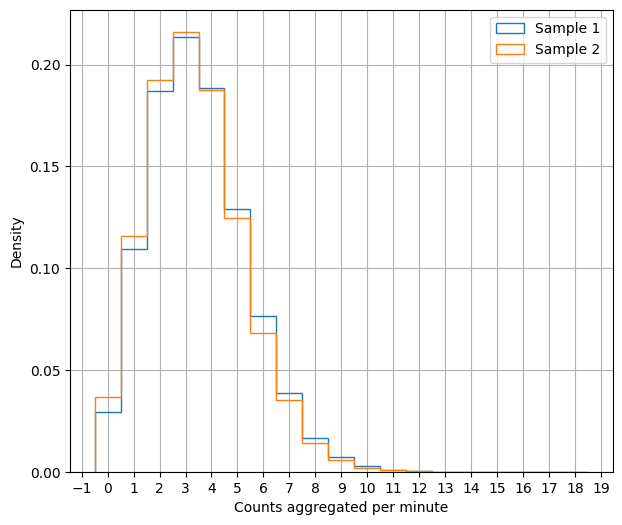

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))

bins = np.arange(start=0, stop=20, step=1) - 0.5
sample_1.plot.hist(y='value', bins=bins, histtype='step', label='Sample 1', density=True, ax=ax)
sample_2.plot.hist(y='value', bins=bins, histtype='step', label='Sample 2', density=True, ax=ax)

ax.grid()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlabel("Counts aggregated per minute")
ax.set_ylabel("Density")
# ax.set_yscale('log')

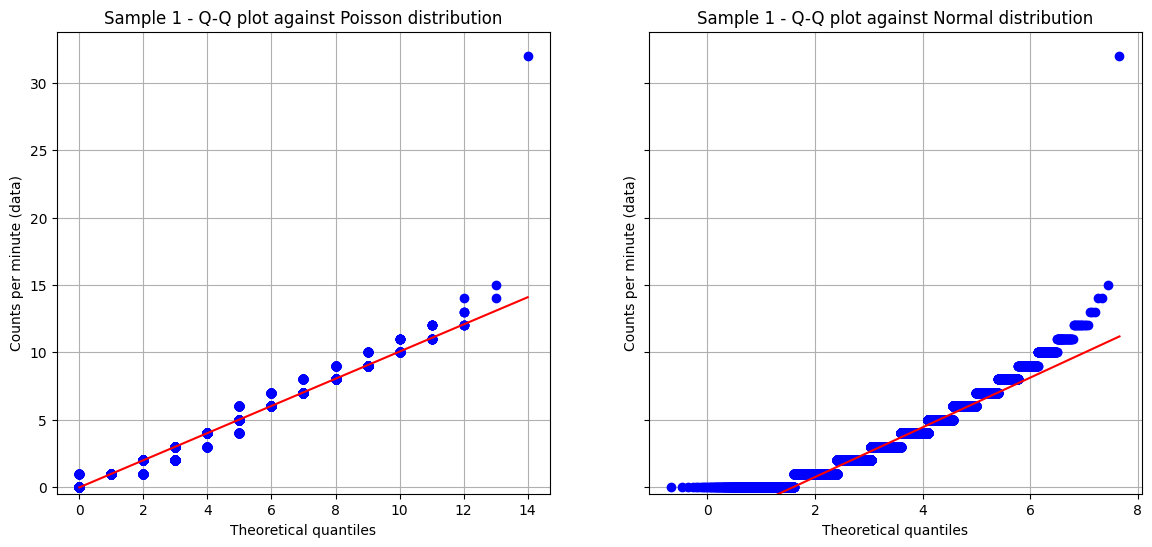

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)
stats.probplot(sample_1['value'], dist="poisson", sparams=(sample_1['value'].mean(),), plot=ax[0]);
ax[0].set_title("Sample 1 - Q-Q plot against Poisson distribution")
stats.probplot(sample_1['value'], dist="norm", sparams=(sample_1['value'].mean(),), plot=ax[1]);
ax[1].set_title("Sample 1 - Q-Q plot against Normal distribution")
for a in ax:
    a.grid();
    a.set_ylim(-0.5, None)
    a.set_ylabel("Counts per minute (data)")

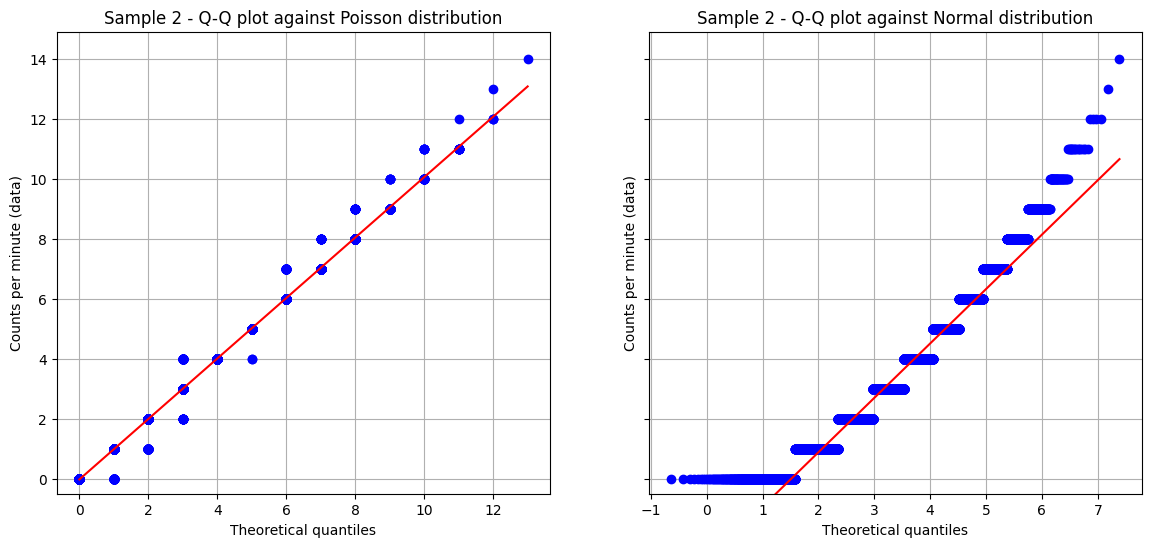

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)
stats.probplot(sample_2['value'], dist="poisson", sparams=(sample_2['value'].mean(),), plot=ax[0]);
ax[0].set_title("Sample 2 - Q-Q plot against Poisson distribution")
stats.probplot(sample_2['value'], dist="norm", sparams=(sample_2['value'].mean(),), plot=ax[1]);
ax[1].set_title("Sample 2 - Q-Q plot against Normal distribution")
for a in ax:
    a.grid();
    a.set_ylim(-0.5, None)
    a.set_ylabel("Counts per minute (data)")

## Anomaly Detection using the `radem` library
Let's visualise the data again. We can spot a notable peak in the data around the middle of december. Below this you can also see that the data from the time around the event has a different distribution - smaller peak and a longer right tail.

In [16]:
likely_anomaly = df_e.query("bin == 1 and time >= '2023-12-13' and time < '2023-12-17'")

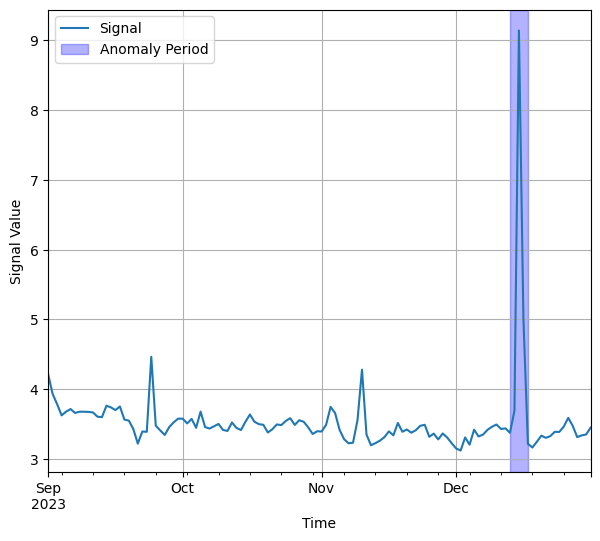

In [17]:
fig, ax = plt.subplots(figsize=(7, 6))

df.groupby(pd.Grouper(key='time', freq='1D'))['value'].mean().plot(ax=ax, label="Signal")
ax.grid()
ax.axvspan('2023-12-13', '2023-12-17', color="blue", alpha=0.3, label="Anomaly Period")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Signal Value");

Text(0, 0.5, 'Density')

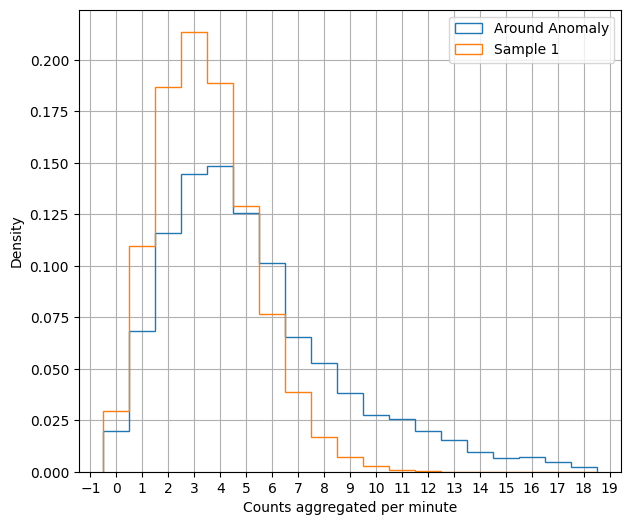

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))

bins = np.arange(start=0, stop=20, step=1) - 0.5
likely_anomaly.plot.hist(y='value', bins=bins, histtype='step', label='Around Anomaly', density=True, ax=ax)
sample_1.plot.hist(y='value', bins=bins, histtype='step', label='Sample 1', density=True, ax=ax)
# sample_2.plot.hist(y='value', bins=bins, histtype='step', label='Sample 2', density=True, ax=ax)

ax.grid()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlabel("Counts aggregated per minute")
ax.set_ylabel("Density")

### Simple threashold approach
We can attempt a simple thresholding approach to find out where the datapoints are above a certain value.

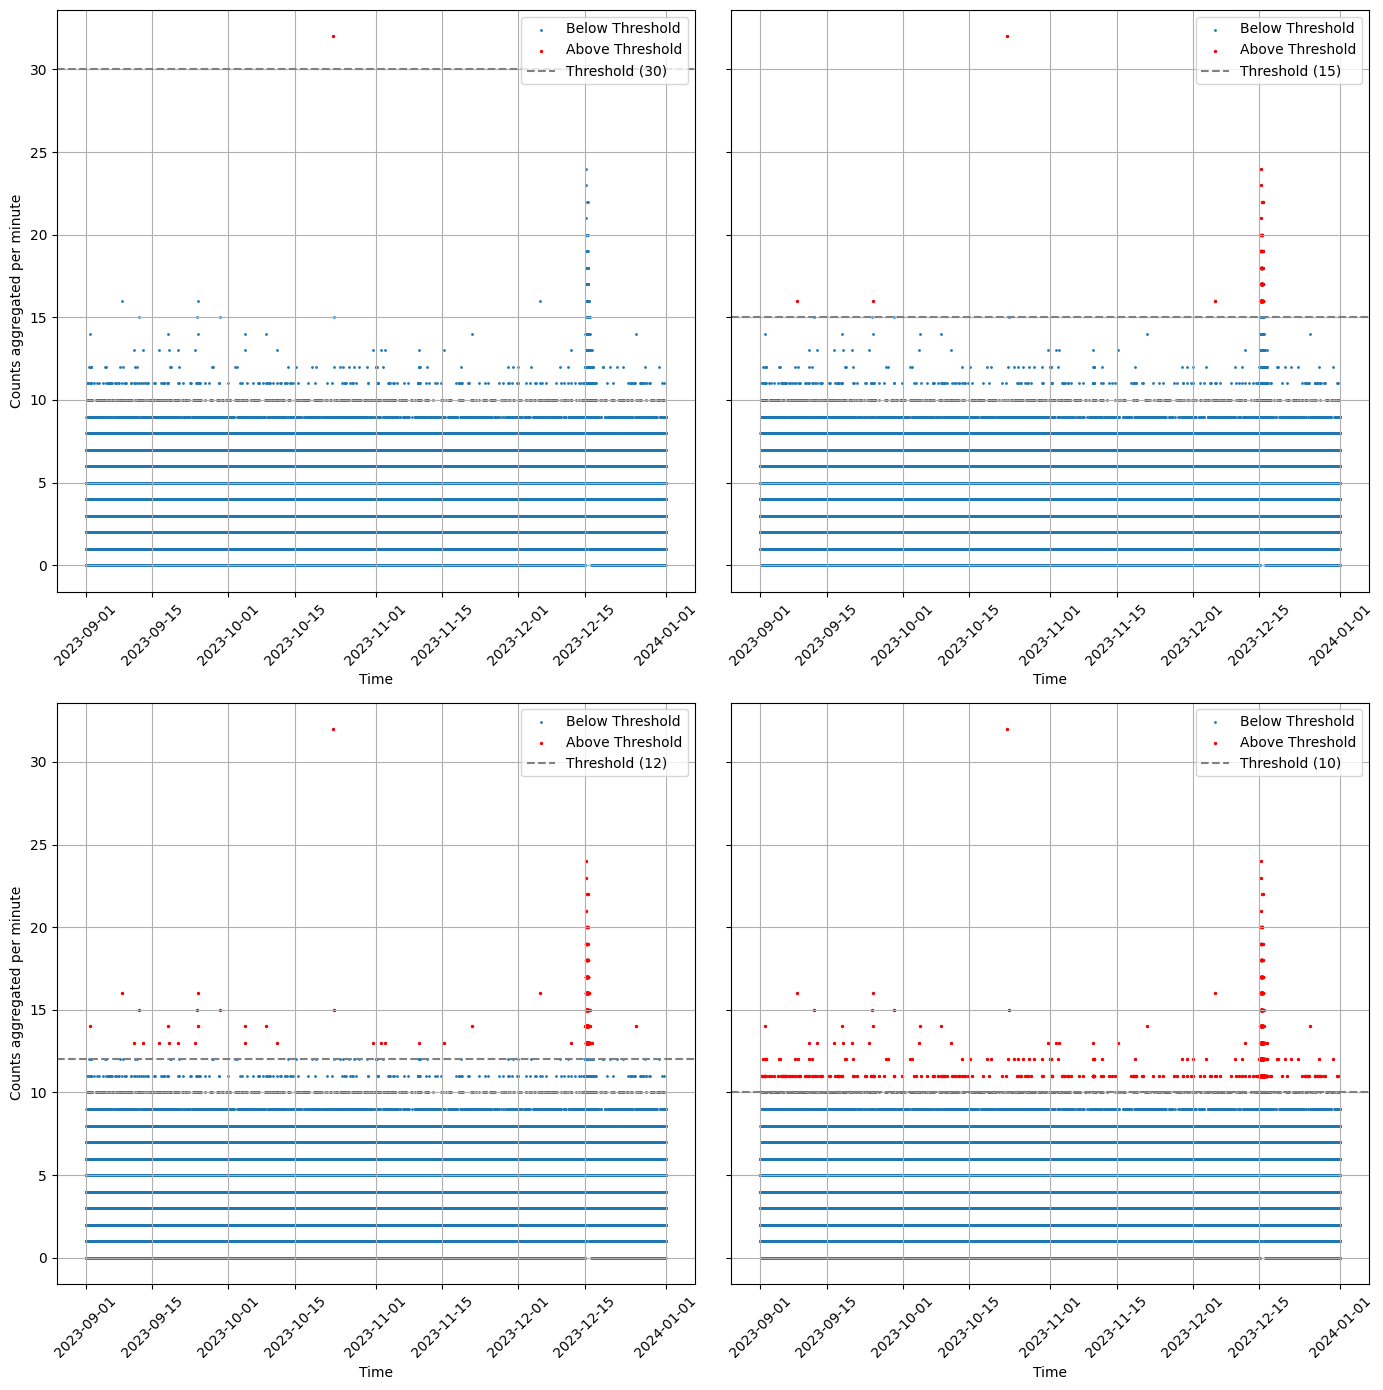

In [19]:

# # Define the threshold
thresholds = [30, 15, 12, 10]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14), sharey=True)

for threshold, ax in zip(thresholds, axs.flatten()):
    ax = df.plot.scatter(x='time', y='value', s=1, ax=ax, label='Below Threshold', legend=True)

    above_threshold = df[df['value'] > threshold]
    ax.scatter(above_threshold['time'], above_threshold['value'], color='red', s=2, label='Above Threshold')

    ax.axhline(threshold, color='gray', linestyle='--', label=f'Threshold ({threshold})')

    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("Time")
    ax.set_ylabel("Counts aggregated per minute")
    ax.grid();
    ax.legend()
fig.tight_layout()

This method does work, considering that all events have a very significant peak, that there are no outliers in the data. Unfortunately it tells us nothing about the base of the peak since a threshold that clasifies the base as a part of the event is simply to low.

### Rolling Z-Score approach
We can use one of the functions from the `events` module. The `autosplit_gauss` function takes in some background signal and an original signal. Then it compares the distribution with a rolling window and returns the begin and end dates of all the events whose Z-Score deviated significantly from the background signal. From preliminary visual checks we've noted that the anomaly is around 2-3 days long. We set our `window_size` acordingly.

In [20]:
anomalies = radem.events.autosplit_gauss(
    background_noise=sample_1, 
    signal=df, 
    window_size=1 * 24 * 60, 
    threshold=2)

mask = radem.events.autosplit_gauss_mask(
    background_noise=sample_1, 
    signal=df, 
    window_size=1 * 24 * 60, 
    threshold=2)

len(anomalies)

1

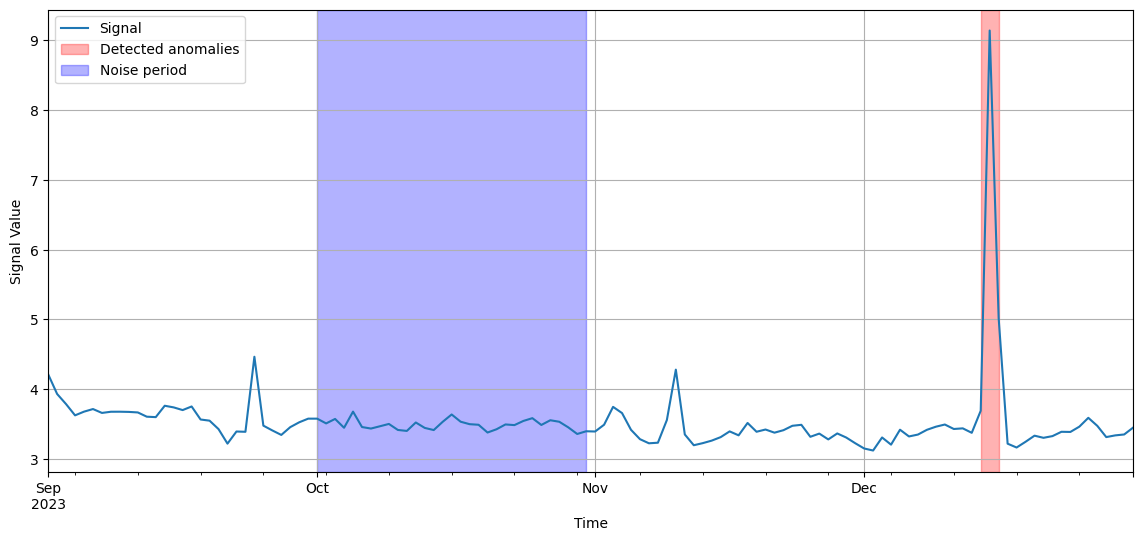

In [21]:
fig, ax = plt.subplots(figsize=(14, 6))

df.groupby(pd.Grouper(key='time', freq='1D'))['value'].mean().plot(ax=ax, label="Signal")
ax.grid()

for start_time, end_time in anomalies:
    ax.axvspan(start_time, end_time, color="red", alpha=0.3, label="Detected anomalies")

ax.axvspan(sample_1['time'].min(), sample_1['time'].max(), color="blue", alpha=0.3, label="Noise period")
ax.set_xlabel("Time")
ax.set_ylabel("Signal Value");
ax.legend()

### A look at the event distribution

In [22]:
anomalous_data = df[mask]

Text(0, 0.5, 'Density')

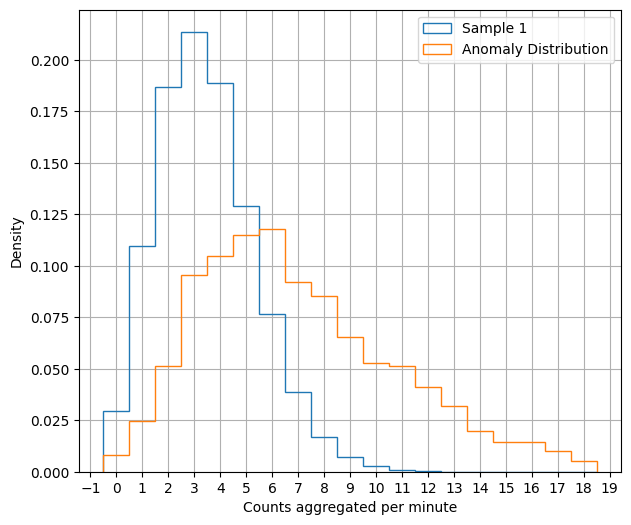

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))

bins = np.arange(start=0, stop=20, step=1) - 0.5
sample_1.plot.hist(y='value', bins=bins, histtype='step', label='Sample 1', density=True, ax=ax)
anomalous_data.plot.hist(y='value', bins=bins, histtype='step', label='Anomaly Distribution', density=True, ax=ax)


ax.grid()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlabel("Counts aggregated per minute")
ax.set_ylabel("Density")

## Poisson-specific tests
Since our data seems to have a poisson distribution we should use a different statistic for comparison of distributions.

In [24]:
anomalies = radem.events.autosplit_poisson(
    background_noise=sample_1, 
    signal=df, 
    window_size=3 * 24 * 60, 
    threshold=3)

mask = radem.events.autosplit_poisson_mask(
    background_noise=sample_1, 
    signal=df, 
    window_size=3 * 24 * 60, 
    threshold=3)

len(anomalies)

5

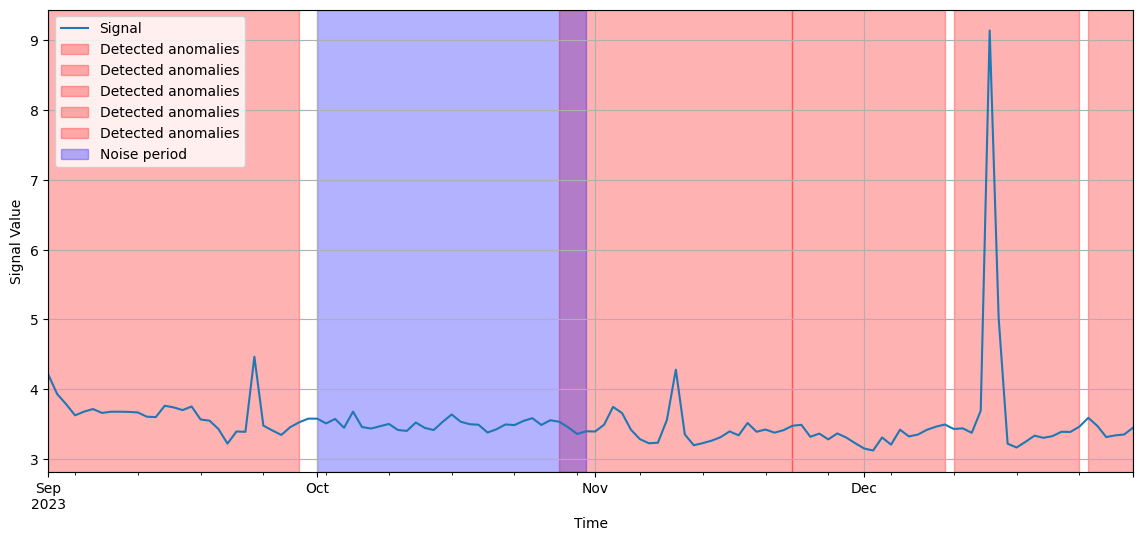

In [25]:
fig, ax = plt.subplots(figsize=(14, 6))

df.groupby(pd.Grouper(key='time', freq='1D'))['value'].mean().plot(ax=ax, label="Signal")
ax.grid()

for start_time, end_time in anomalies:
    ax.axvspan(start_time, end_time, color="red", alpha=0.3, label="Detected anomalies")

ax.axvspan(sample_1['time'].min(), sample_1['time'].max(), color="blue", alpha=0.3, label="Noise period")
ax.set_xlabel("Time")
ax.set_ylabel("Signal Value");
ax.legend()

In [26]:
anomalous_data = df[mask]

Text(0, 0.5, 'Density')

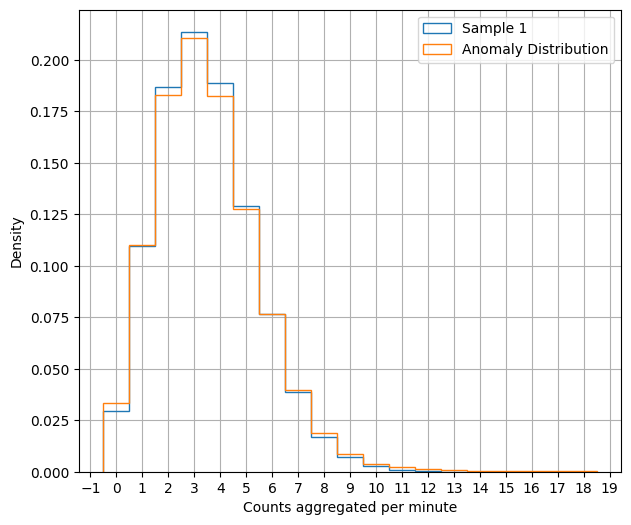

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))

bins = np.arange(start=0, stop=20, step=1) - 0.5
sample_1.plot.hist(y='value', bins=bins, histtype='step', label='Sample 1', density=True, ax=ax)
anomalous_data.plot.hist(y='value', bins=bins, histtype='step', label='Anomaly Distribution', density=True, ax=ax)


ax.grid()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlabel("Counts aggregated per minute")
ax.set_ylabel("Density")